### Word2Vec training 

In [205]:
# imports needed
import gensim 
import pandas as pd
import numpy as np
import random
import unidecode
import re
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from  nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#### 1 load and clean tweets

In [208]:
filename='/Users/Michi/Google Drive/formation_data_science/twitter_project/help_dicrah/machine_learning/tweets_dilcrah_60k.csv'
#Streams/stream_#Web2day OR #aidessociales.jsonl'
#Users/help_dicrah_large_random_sample.jsonl'

def read_json_files(path_to_file):
    with open(path_to_file) as p:
        data = pd.read_json(p, lines=True)
    return data

#df = read_json_files(filename)
df = pd.read_csv(filename, header=None,
                 names=['tweet'], index_col=None)#.drop_duplicates(subset='id')

df.head()

,tweet
997565477458243584,@AngeFreddy Pouloulouuuu
957325640465862656,@R0eil Nan😂
1006280333573181441,@Coldmindxd LAQUELLE.
834864840359473157,"Je me dis que dans 20 ans, j'ai 40 ans 🤔🤔"
1005911475934912522,Le mieux qu’ils puissent faire ... https://t.c...


In [209]:
#print(df.tweet[np.random.randint(0,df.shape[0])])
#df = df[['id','full_text']].drop_duplicates(subset='id')
df.head()
print(df.tweet[58])
df.shape

,tweet
997565477458243584,@AngeFreddy Pouloulouuuu
957325640465862656,@R0eil Nan😂
1006280333573181441,@Coldmindxd LAQUELLE.
834864840359473157,"Je me dis que dans 20 ans, j'ai 40 ans 🤔🤔"
1005911475934912522,Le mieux qu’ils puissent faire ... https://t.c...


@americanflagusa @Philome17321717 Grace au grand Mufti fossoyeur de la Françe https://t.co/vZbOcJ1zwo


(47199, 1)

In [213]:

my_dict={"aujourd'hui":"aujourdhui", "s'il":"si il", "s'":"se ","n'":"ne ", 'jte':"je te", 'pck':'parce que', 'jms':'jamais',
        'fdp': 'fis de pute', 'ptn': 'putaine', 'pcq':'parce que', 'tt ': 'toute', 'vrmt': 'vraiment',
         "m'a'": 'me a','ptdr':" plie tordu de rire", "c'est":"ce est","m'":"me ", "jrnee":"jourrnee"}


def tweet_cleaner(text, my_dict):
        
    # fixes encoding problem (MICHELE)
    if type(text)!=unicode and type(text)!=float:
        try: 
            text= unicode(text,'utf-8')
        except UnicodeDecodeError: 
            text= unicode(text,'latin-1')
    if type(text)==float:
        text = str(text)
    
    tok = WordPunctTokenizer()

    pat1 = r'@[A-Za-z0-9_]+'
    pat2 = r'https?://[^ ]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www.[^ ]+'
    rt_path = r'^rt'
    paths =  [combined_pat, www_pat,rt_path ]
    
        
    text = unidecode.unidecode(text)
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    
    for word in my_dict:
        souped = re.sub(word, my_dict[word], souped)
    
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    
    for path in paths:
        bom_removed = re.sub(path, '', bom_removed.lower())
    
    letters_only = re.sub("[^a-zA-Z]", " ", bom_removed)
    
 
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) >= 1]
    return (" ".join(words)).strip()


def tokenize(text):
    tweet = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
    stemmer = FrenchStemmer()
    tokens = [stemmer.stem(t) for t in tweet.split() if len(stemmer.stem(t))>2 ]
    return tokens

def generate_stopwords():
    stopwords_en = nltk.corpus.stopwords.words("english")
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_en+stopwords_fr
    #other_exclusions = ["#ff", "ff", "rt"]
    #stop_words.extend(other_exclusions)
    return stop_words

def remove_stopwords(text_list, sw):
    return [word for word in text_list if word not in sw]

In [214]:
text=df.tweet[np.random.randint(0,df.shape[0])]
print(text)
tweet_cleaner(text, my_dict)

@orlane_fow T'aimes pas que moi aux dernières nouvelles #mercredi


u't aimes pas que moi aux dernieres nouvelles mercredi'

In [215]:
#clean_tweets = [tweet_cleaner(str(tweet), my_dict) for tweet in list(df['full_text'])]

df['clean_tweets'] = df.tweet.apply(lambda x:' '.join(remove_stopwords(tokenize(tweet_cleaner(x, my_dict)), generate_stopwords())))

#df['clean_tweets'] = clean_tweets
df.shape
df.head(5)

(47199, 2)

,tweet,clean_tweets
997565477458243584,@AngeFreddy Pouloulouuuu,pouloulouuuu
957325640465862656,@R0eil Nan😂,nan
1006280333573181441,@Coldmindxd LAQUELLE.,laquel
834864840359473157,"Je me dis que dans 20 ans, j'ai 40 ans 🤔🤔",dis dan
1005911475934912522,Le mieux qu’ils puissent faire ... https://t.c...,mieux puissent fair


In [216]:
df =df.drop_duplicates(subset='clean_tweets')
df.shape

(36570, 2)

In [217]:
df['nc'] = [len(t) for t in df.clean_tweets]
df = df.drop(df[df.nc < 2].index).drop('nc', axis=1)
df.shape

(36569, 2)

#### 2 Word2Vec representation

In [218]:
# list of list of words
documents = [tokenize(tweet) for tweet in list(df['clean_tweets'])]
#for tweet in list(df['clean_tweets']):
#    documents.append(tweet.split())

print(documents[:3])

[[u'pouloulouuuu'], [u'nan'], [u'laquel']]


In [219]:
model = gensim.models.Word2Vec(documents, size=200, window=10, min_count=1, workers=10)
model.train(documents, total_examples=len(documents), epochs=10)

(2909082, 3021970)

In [220]:
w = "put"
print("mots proches de ", w)
model.wv.most_similar(positive=w, topn=5)

('mots proches de ', 'put')


[(u'fis', 0.9348027110099792),
 (u'epicgam', 0.9235101938247681),
 (u'fil', 0.9152531623840332),
 (u'sal', 0.912577748298645),
 (u'dton', 0.906657338142395)]

#### 3 Word2Vec features

In [221]:
# dictionary mapping word --> 150-dimensional vector 
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [172]:
# w2v.keys()

In [222]:
class TfidfEmbeddingVectorizer(object):
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X):
        tfidf = TfidfVectorizer()
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        print(max_idf)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words.split(' ') if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [223]:
tweet_file = '/Users/Michi/Google Drive/formation_data_science/twitter_project/help_dicrah/machine_learning/_Tweets_labels_manuels.xlsx'

tw_data = pd.read_excel(tweet_file)
tw_data.loc[tw_data.Label=='SH', 'Label']='S'
tw_data.loc[tw_data.Label=='H', 'Label']='S'

tw_data['Texte_clean'] = tw_data.Texte.apply(lambda x:' '.join(remove_stopwords(tokenize(tweet_cleaner(x, my_dict)), generate_stopwords())))

tw_data.Label.value_counts()
tw_data.head(5)

N    801
S    199
Name: Label, dtype: int64

,ID,Texte,Label,Texte_clean
0,998206424189751296,On m’avait sorti (pour de vrai) « on est tous ...,N,sort vrai tous egal plus parl racism plus gen ...
1,997896508384169984,VIVE L AMOUR ❤VIVE LA PAIX\n❤❤❤❤❤❤❤❤❤❤❤❤👏👍\n...,N,viv amour viv paix entre peupl mond stop racis...
2,31,J'me rend compte à quel point ya trop d'noir d...,S,rend compt quel point trop noir dan enfait tro...
3,998519485467414529,@KrypsKarmaKid Tu traites qui de salope la seu...,S,trait salop seul salop con mer put sal mtn sto...
4,997799245464899584,Voilà à quoi tu dois me servir sale pute ! Ta ...,S,voil quoi dois serv sal put seul utilit mainte...


In [224]:
my_vectorizer = TfidfEmbeddingVectorizer(w2v)

my_vectorizer.fit(tw_data.Texte_clean)

7.21560759876


In [225]:
#my_vectorizer.word2vec['racist']
my_vectorizer.word2weight['put']
np.mean([my_vectorizer.word2vec['put'] * my_vectorizer.word2weight['put']], axis=0)[:5]

3.81441021709312

array([-3.78942466,  2.57184982,  1.79630756,  2.83961678,  2.95204949], dtype=float32)

In [226]:
tw_data.Texte_clean.iloc[1:3]

1    viv amour viv paix entre peupl mond stop racis...
2    rend compt quel point trop noir dan enfait tro...
Name: Texte_clean, dtype: object

In [227]:
features = my_vectorizer.transform(tw_data.Texte_clean)
features[:2,:2]

array([[-1.95606983, -1.37524235],
       [-1.34796727, -1.33702421]], dtype=float32)

# ML

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report


In [229]:
#X = pd.DataFrame(M)
tw_data['Label_id']=tw_data['Label'].factorize()[0]
label_id_df_fr = tw_data[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
label_to_id_fr = dict(label_id_df_fr.values)

y = tw_data['Label_id'].as_matrix()

label_to_id_fr

{u'N': 0, u'S': 1}

In [230]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=42, test_size=0.15)

In [231]:
X_train.shape

(850, 200)

In [232]:
from sklearn.decomposition import PCA, RandomizedPCA

n_components = 2
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape
y_train.shape

(850, 2)

(850,)

In [233]:
np.append(X_train_pca, y_train.reshape(y_train.shape[0],1), axis=1)

array([[-0.48746872, -0.79413766,  1.        ],
       [ 0.90882617, -0.20888971,  0.        ],
       [-0.26615509, -1.67123544,  0.        ],
       ..., 
       [-0.35911959, -0.64149302,  0.        ],
       [-0.20846885, -0.14318195,  1.        ],
       [-0.38262492, -0.80208462,  0.        ]])

In [234]:
tw_data_pca = pd.DataFrame(data=np.append(X_train_pca, y_train.reshape(y_train.shape[0],1), axis=1), columns=['P1','P2','Label'])

tw_data_pca.head(5)

,P1,P2,Label
0,-0.487469,-0.794138,1.0
1,0.908826,-0.208890,0.0
2,-0.266155,-1.671235,0.0
3,2.669575,0.287564,0.0
4,-0.482069,0.136829,0.0


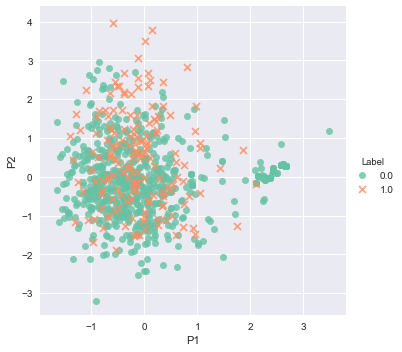

In [235]:

sns.lmplot(x="P1", y="P2", data=tw_data_pca, fit_reg=False, hue='Label', legend=True, markers=["o", "x"], palette="Set2")



In [236]:
from sklearn import linear_model

model = linear_model.LogisticRegression(C=1.)

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [237]:
y_preds = model.predict(X_test)
print(classification_report( y_test, y_preds ))

             precision    recall  f1-score   support

          0       0.86      0.93      0.89       122
          1       0.53      0.32      0.40        28

avg / total       0.80      0.82      0.80       150



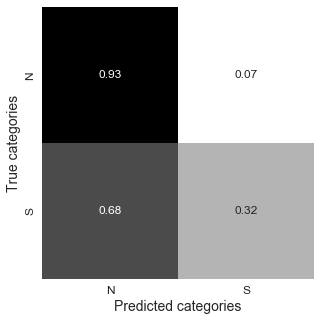

In [238]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['N','S']
confusion_df = pd.DataFrame(matrix_proportions, 
                            index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,
            annot_kws={"size": 12},cmap='gist_gray_r',
            cbar=False, square=True,fmt='.2f');
plt.ylabel(r'True categories',fontsize=14);
plt.xlabel(r'Predicted categories',fontsize=14);
plt.tick_params(labelsize=12);

